# Yankees - Event Propensity - Next Event Buyer
* StelllarAlgo Data Science
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ·····················


In [3]:
cursor = CNXN.cursor()

query =  f"""
    SELECT
        dimCustomerMasterId,
        recent_openRate,
        recent_clickRate,
        eventDate,
        inMarket,
        distanceToVenue,
        did_purchase,
        events_purchased,
        frequency_opponent,
        frequency_eventDay,
        frequency_eventTime
    FROM DataScience.yankees.event_propensity_training
    """
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341266 entries, 0 to 341265
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dimCustomerMasterId  341266 non-null  int64         
 1   recent_openRate      341266 non-null  float64       
 2   recent_clickRate     341266 non-null  float64       
 3   eventDate            341266 non-null  datetime64[ns]
 4   inMarket             299741 non-null  object        
 5   distanceToVenue      299741 non-null  float64       
 6   did_purchase         341266 non-null  int64         
 7   events_purchased     341266 non-null  int64         
 8   frequency_opponent   341266 non-null  float64       
 9   frequency_eventDay   341266 non-null  float64       
 10  frequency_eventTime  341266 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 28.6+ MB


In [ ]:
#profile = ProfileReport(df, minimal=True)
#profile.to_file(output_file="yankees_pandas_profile_events.html")

### We should specify the features used in our model:

In [5]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (290076, 11)
Unseen Data For Predictions: (51190, 11)



In [6]:
df_train.head()

,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,inMarket,distanceToVenue,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
141211,23861648,0.0,0.0,2019-09-20,True,47.50,1,3,0.00,0.000000,0.000000
124283,3067056,0.0,0.0,2019-09-18,None,NaN,0,123,0.00,0.000000,0.014085
216305,700267,0.0,0.0,2019-09-03,True,9.54,0,118,0.00,0.000000,0.000000
226455,1055646,0.0,0.0,2017-08-01,False,3263.22,0,36,0.00,0.166667,0.041667
269684,2009681,0.0,0.0,2019-06-11,True,30.32,1,103,0.25,0.066667,0.000000


### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [7]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=["dimCustomerMasterId"],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate"
    ]
);

In [9]:
model_matrix = compare_models(
    fold=10,
    #include=["lightgbm","xgboost"]
    sort="auc"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8392,0.9105,0.8466,0.8338,0.8402,0.6784,0.6785,5.4570
lightgbm,Light Gradient Boosting Machine,0.8366,0.9083,0.8461,0.8300,0.8379,0.6733,0.6734,1.2290
gbc,Gradient Boosting Classifier,0.8251,0.8983,0.8218,0.8269,0.8243,0.6503,0.6503,6.9320
rf,Random Forest Classifier,0.8208,0.8944,0.8139,0.8249,0.8193,0.6416,0.6417,7.0540
et,Extra Trees Classifier,0.8074,0.8770,0.7993,0.8120,0.8056,0.6147,0.6148,10.4730
ada,Ada Boost Classifier,0.7813,0.8586,0.7623,0.7919,0.7768,0.5627,0.5631,1.6370
knn,K Neighbors Classifier,0.7322,0.8002,0.7417,0.7273,0.7344,0.4644,0.4645,7.8210
lr,Logistic Regression,0.7364,0.7969,0.7797,0.7170,0.7471,0.4729,0.4747,1.4520
lda,Linear Discriminant Analysis,0.7281,0.7906,0.7870,0.7036,0.7429,0.4563,0.4596,0.3700
dt,Decision Tree Classifier,0.7706,0.7712,0.7754,0.7676,0.7715,0.5413,0.5413,0.3850


In [10]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8414,0.9112,0.8458,0.8380,0.8419,0.6828,0.6828
1,0.8426,0.9140,0.8529,0.8353,0.8440,0.6853,0.6854
2,0.8386,0.9092,0.8430,0.8352,0.8391,0.6772,0.6772
3,0.8390,0.9114,0.8464,0.8336,0.8400,0.6779,0.6780
4,0.8341,0.9055,0.8439,0.8272,0.8355,0.6682,0.6683
5,0.8415,0.9120,0.8533,0.8333,0.8432,0.6831,0.6833
6,0.8378,0.9098,0.8413,0.8351,0.8382,0.6757,0.6757
7,0.8389,0.9098,0.8432,0.8357,0.8394,0.6778,0.6779
8,0.8353,0.9084,0.8457,0.8281,0.8368,0.6706,0.6708
9,0.8427,0.9134,0.8507,0.8369,0.8437,0.6853,0.6854


### Let's load in our evaluation data and get propensity scores using the model:

In [11]:
df_inference = predict_model(final_model, data=df_eval, raw_score=True)

df_inference.head()

,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,inMarket,distanceToVenue,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,Label,Score_0,Score_1
8,3654,0.0,0.000000,2018-05-09,True,81.90,0,84,0.000000,0.0,0.000000,0,0.8722,0.1278
15,5249,0.6,0.333333,2018-05-25,True,29.99,0,63,0.000000,0.0,0.000000,0,0.7436,0.2564
29,9482,0.0,0.000000,2019-05-18,True,12.15,1,0,0.000000,0.0,0.000000,1,0.0249,0.9751
33,10150,2.5,0.300000,2018-04-25,True,37.99,1,2,0.000000,0.0,0.000000,1,0.1579,0.8421
41,12001,1.5,0.000000,2021-07-18,True,8.76,0,305,0.029412,0.0,0.057471,1,0.4804,0.5196


In [13]:
print("Would not purchase:", df_inference["Label"].value_counts()[0])
print("Would purchase:", df_inference["Label"].value_counts()[1])

Would not purchase: 25219
Would purchase: 25971


### Score_0 = Would not purchase, Score_1 = Would purchase

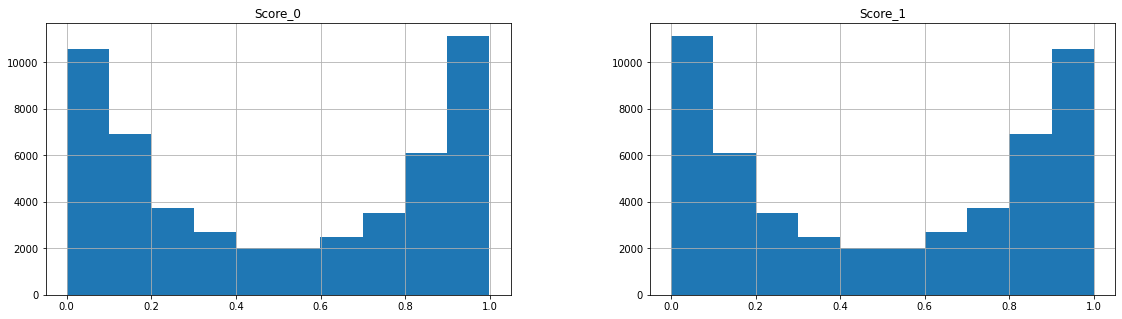

In [14]:
df_inference.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

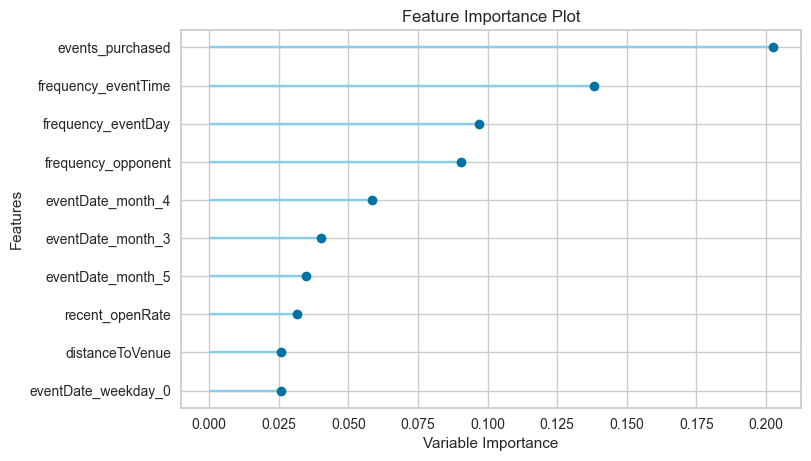

In [15]:
plot_model(best_model, plot='feature')

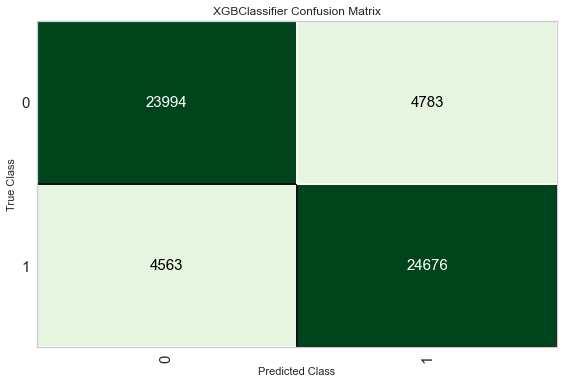

In [16]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.